# Predicting Hospital Discharge Outcomes

In this code, we will explore a dataset of patient hospital discharge outcomes as a function of the treatment they receive. We will then examine the business value of the predictive model for UVA Hospital. Finally, we learn how to use cost-sensitive training to maximize the business value of the predictive model.

## 1. Import packages

First, we will import our normal selection of packages. However, this time, we will be importing the classification version of the models we've been using. These will have different names, but generally, the parameters will be identical or nearly so.

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * 
# Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting
from sklearn.pipeline import Pipeline
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

## 2. Load the Data

In [2]:
trainInput = pd.read_csv("DischargeTrain.csv")
testInput = pd.read_csv("DischargeTest.csv")

In [3]:
trainInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,33434057,Home Health Agency,298873,Female,Single,Medicare Replacement,NaN,54,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38150727,Infusion / Home,165661,Male,Divorced,Do not use,NaN,58,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
testInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,37607139,Skilled Nursing Facility (SNF),227723,Female,Divorced,Medicare,NaN,89,0,10,...,0,0,0,0,0,0,0,0,18,0
1,34657024,Skilled Nursing Facility (SNF),188569,Female,Widowed,Medicare,NaN,80,0,0,...,0,0,0,0,0,0,0,0,16,0


Let's take a look at the shape of these dataframes.

In [5]:
trainInput.shape

(17435, 833)

In [6]:
testInput.shape

(5812, 833)

Before moving forward, we need to create our target variable. Our target variable should be equal to 1 if the discharge needs paperwork, and 0 otherwise. Let's take a look at the discharge types and then determine which ones require paperwork:

In [7]:
trainInput['Discharge_Type'].value_counts()

Discharge_Type
Home Health Agency                                        5696
HOME                                                      4790
Skilled Nursing Facility (SNF)                            3025
Acute Rehabilitation Facility (hospital or unit) (IRF)    1150
EXPIRED                                                    972
Infusion / Home                                            712
Long Term Care Hospital (LTCH)                             395
Hospice / Home                                             367
DIS TO LAW ENFORCE                                         166
AGAINST MED ADVICE                                         162
Name: count, dtype: int64

The types of discharge that require additional paperwork are `Skilled Nursing Facility (SNF)`, `Acute Rehabilitation Facility (hospital or unit) (IRF)`, and `Long Term Care Hospital (LTCH)`, so we will create a new variable which is `1` if any of those three are the discharge type or `0` if not.

In [8]:
trainInput['Requires_Paperwork'] = \
np.where(trainInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

trainInput['Requires_Paperwork'].value_counts()

Requires_Paperwork
0    12865
1     4570
Name: count, dtype: int64

In [9]:
testInput['Requires_Paperwork'] = \
np.where(testInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

testInput['Requires_Paperwork'].value_counts()

Requires_Paperwork
0    4267
1    1545
Name: count, dtype: int64

Now, we can go ahead and separate our x and y. Given that `Requires_Paperwork` is still fully correlated with our new y (`Requires_Paperwork`), we have to drop that as well. In addition, `Unique_Patient_Encounter_ID` and `Unique_Patient_ID` are unique identifiers and therefore there is no value in using them as predictors. So, we drop these columns too. Also, because our y values (labels) are already 0s and 1s, we don't need LabelEncode them anymore:

### Quick EDA

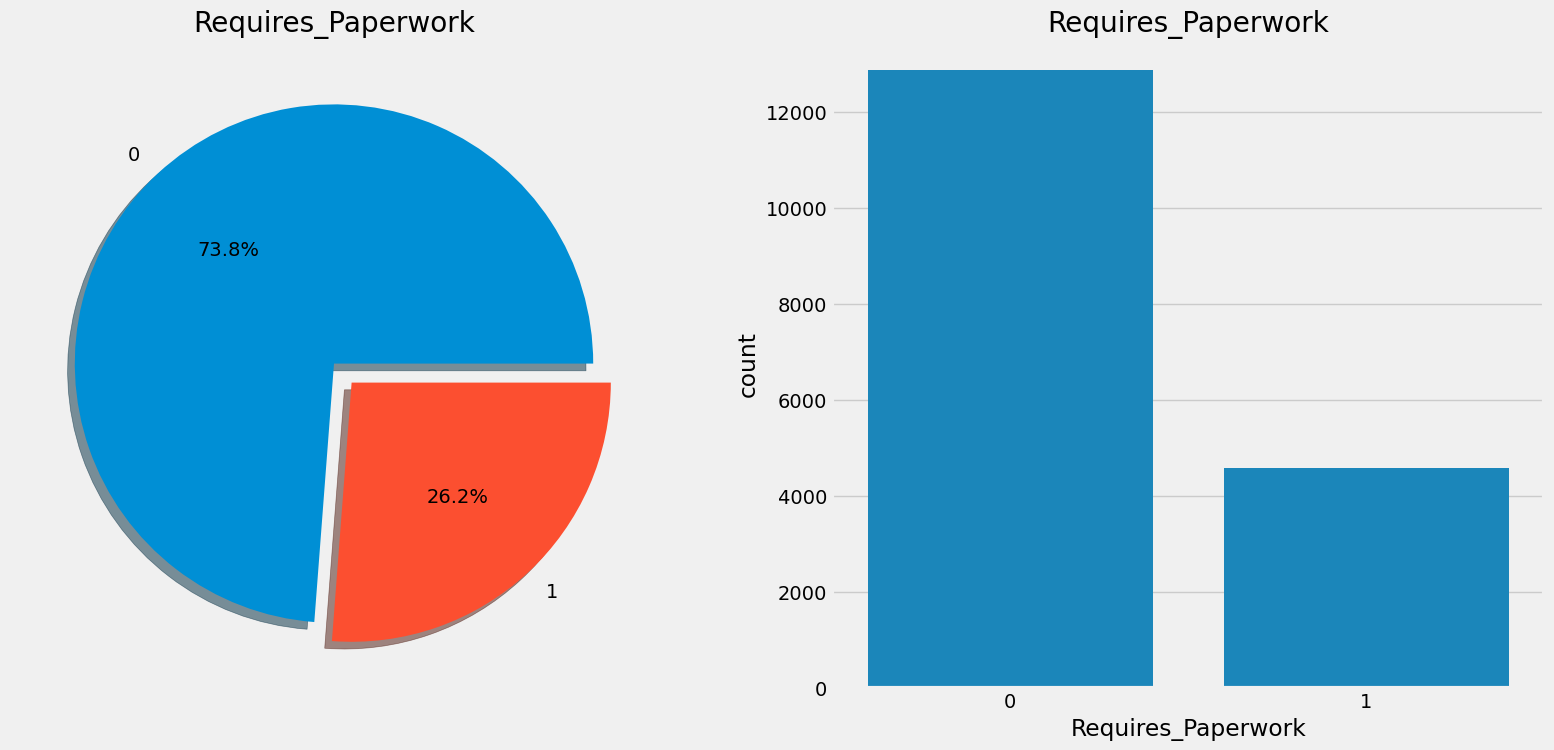

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot the pie chart
trainInput['Requires_Paperwork'].value_counts().plot.pie(
    explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True
)
ax[0].set_title('Requires_Paperwork')
ax[0].set_ylabel('')

# Plot the countplot
sns.countplot(x='Requires_Paperwork', data=trainInput, ax=ax[1])
ax[1].set_title('Requires_Paperwork')

plt.show()

In [ ]:
# Get all columns except Requires_Paperwork
columns = [col for col in trainInput.columns if col != "Requires_Paperwork"]

# Loop through each column and display crosstab with background gradient
for col in columns:
    if trainInput[col].dtype == "object" or trainInput[col].nunique() < 10:  # Only for categorical/low unique value columns
        print(f"\n🔹 Crosstab: {col} vs Requires_Paperwork\n")
        
        # Compute crosstab
        crosstab = pd.crosstab(trainInput[col], trainInput["Requires_Paperwork"], margins=True)
        
        # Calculate the ratio of "Requires_Paperwork" = 1
        crosstab["Ratio_Requires_Paperwork"] = crosstab[1] / crosstab["All"]
        
        # Format the ratio column (reduce decimals)
        styled_crosstab = crosstab.style.background_gradient(cmap="summer_r") \
            .format({"Ratio_Requires_Paperwork": "{:.2%}"}) \
            .set_properties(**{"text-align": "center"}) \
            .set_table_styles([{"selector": "th", "props": [("text-align", "center")]}])
        
        # Display
        display(styled_crosstab)



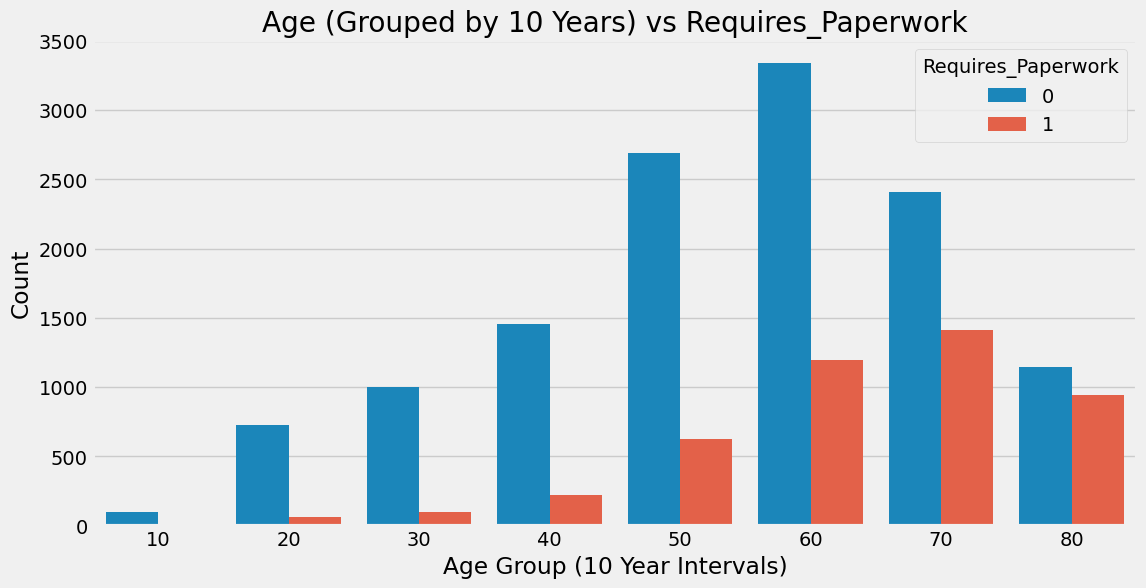

In [12]:
# Create a temporary age group column without modifying the original DataFrame
trainInput_copy = trainInput.copy()
trainInput_copy["Age Group"] = (trainInput_copy["Age"] // 10) * 10  # Group ages into 10-year bins

# Create a single subplot
f, ax = plt.subplots(1, 1, figsize=(12, 6))

# Countplot with age groups
sns.countplot(x="Age Group", hue="Requires_Paperwork", data=trainInput_copy, ax=ax)
ax.set_title("Age (Grouped by 10 Years) vs Requires_Paperwork")
ax.set_xlabel("Age Group (10 Year Intervals)")
ax.set_ylabel("Count")

plt.show()

### Back to Starter

In [13]:
trainData = trainInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                       'Unique_Patient_ID',
                                       'Requires_Paperwork',
                                      'Discharge_Type'])
trainLabels = trainInput.Requires_Paperwork

testData = testInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                     'Unique_Patient_ID',
                                     'Requires_Paperwork',
                                      'Discharge_Type'])
testLabels = testInput.Requires_Paperwork

In [14]:
testLabels.head(1)

0    1
Name: Requires_Paperwork, dtype: int64

## 3. Data Augmentations

In [15]:
!pip install feature-engine

In [31]:
enc = WoEEncoder(add_missing_category=True, add_positive_category=True)

# Apply Weight of Evidence encoding on trainData and testData
trainData, testData = enc.fit_transform(trainData, trainLabels), enc.transform(testData)

TypeError: WoEEncoder.__init__() got an unexpected keyword argument 'add_missing_category'

### 3.1. Treat Missing Values

Before starting the data augmentations, we need to check if we have any columns with missing values. If so, we need to process them first:

In [ ]:
trainData.columns[trainData.isnull().any()].tolist()

In [ ]:
testData.columns[testData.isnull().any()].tolist()

This column captures the previous discharge type if known. Given that many patients may not have a previous discharge status, or their previous discharge could be related to years ago, we just replace the missing values under this column with "Unkown":

In [20]:
from feature_engine.imputation import CategoricalImputer

imp = CategoricalImputer(imputation_method = 'missing',
                            fill_value = "Unknown")

trainData, testData = imp.fit_transform(trainData), imp.transform(testData)

In [ ]:
trainData.Previous_Discharge_Type.value_counts()

In [ ]:
testData.Previous_Discharge_Type.value_counts()

### 3.2. Treat Rare Categories

In [ ]:
from feature_engine.encoding import RareLabelEncoder
#.1
enc = RareLabelEncoder(tol=0.04, n_categories = 2)

trainData, testData = enc.fit_transform(trainData), enc.transform(testData)

In [ ]:
trainData.Previous_Discharge_Type.value_counts()

### 3.3. Drop Psudo-Constant Features (Small Variation)

In [ ]:
from feature_engine.selection import DropConstantFeatures
#.95
con = DropConstantFeatures(tol=.95)

trainData, testData = con.fit_transform(trainData), con.transform(testData)

In [ ]:
trainData.shape

### 3.4. Drop Correlated Columns

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
#.4
sc = SmartCorrelatedSelection(threshold = .65)

trainData, testData = sc.fit_transform(trainData), sc.transform(testData)

In [ ]:
trainData.shape

### 3.5. Treat Outliers

In [ ]:
from feature_engine.outliers import Winsorizer

out = Winsorizer(tail = "both")

trainData, testData = out.fit_transform(trainData), out.transform(testData)

### 3.6. Remove the Remaining Redundant Features

Given that we have 800+ predictors in this data, we start with removing redundant features to decrease the number of predictors:

In [ ]:
%%time
from feature_engine.selection import SelectByInformationValue
#.05
cor = SelectByInformationValue(threshold = .05)

trainData, testData = cor.fit_transform(trainData,trainLabels), cor.transform(testData)

In [ ]:
trainData.shape

### 3.7. Encode the Categorical Features

In [22]:
trainData.select_dtypes('object')

,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type
0,Female,Single,Medicare Replacement,Unknown
1,Male,Divorced,Do not use,Unknown
2,Male,Married,Medicare Managed Care,Unknown
3,Female,Married,Medicare Replacement,Unknown
4,Female,Married,Medicare,Skilled Nursing Facility (SNF)
...,...,...,...,...
17430,Male,Married,Grant,Unknown
17431,Female,Widowed,Medicare,Unknown
17432,Female,Married,Medicare,Unknown
17433,Female,Married,Blue Shield,Unknown


In [23]:
trainData.Marital_Status.unique()

array(['Single', 'Divorced', 'Married', 'Widowed', 'Legally Separated',
       'Other'], dtype=object)

In [24]:
from feature_engine.encoding import WoEEncoder

enc = WoEEncoder()

trainData, testData = enc.fit_transform(trainData,trainLabels), enc.transform(testData)

ValueError: During the WoE calculation, some of the categories in the following features contained 0 in the denominator or numerator, and hence the WoE can't be calculated: Marital_Status, Previous_Discharge_Type.

In [ ]:
trainData.Marital_Status.unique()

## 4. Train/ Evaluate The Classifier

In [ ]:
xgb = XGBClassifier(random_state=0)
xgb.fit(trainData, trainLabels)

In [ ]:
predictedProbabilities = xgb.predict_proba(testData)
predictedLabels = xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

## 4.1 AutoML

In [ ]:
# !pip install mljar-supervised

In [ ]:
# from supervised.automl import AutoML

In [ ]:
#%%capture --no-display
#aml = AutoML(model_time_limit = 50,
                     #eval_metric="auc",
                     #algorithms=["CatBoost", "LightGBM", "Xgboost"],
                     #validation_strategy={
        #"validation_type": "kfold",
        #"k_folds": 5,
        #"shuffle": False,
        #"stratify": True,
   # }
  #                  )

#aml.fit(trainData, trainLabels)

In [ ]:
#aml.report()

## 4.2 Catboost

In [ ]:
%pip install catboost

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(random_seed=0, verbose=0)  
cat.fit(trainData, trainLabels)

In [ ]:
predictedProbabilities = cat.predict_proba(testData)
predictedLabels = cat.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(cat, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

## 4.3 LightGBM

In [ ]:
import lightgbm as lgb
# Rename columns to remove special characters
trainData.columns = [col.replace(" ", "_").replace(",", "_") for col in trainData.columns]

# Initialize and train the LightGBM model
lgb = lgb.LGBMClassifier(random_state=0)
lgb.fit(trainData, trainLabels)


In [ ]:
predictedProbabilities = lgb.predict_proba(testData)
predictedLabels = lgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(lgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

## 5. Catboost Optuna

In [ ]:
%pip install Optunahub

In [ ]:
import os
import pickle
import optuna

# File name for the saved model
filename = "final_catboost.sav"

# Check if the model file exists
if os.path.exists(filename):
    print(f"'{filename}' found. Loading the model and skipping training...")
    with open(filename, "rb") as file:
        loaded_model = pickle.load(file)
    print("Model loaded successfully. You are now ready to analyze.")
else:
    print(f"'{filename}' not found. Training a new model...")

    # Define objective function for Optuna
    def optimize_auc(trial):
        # Define hyperparameter search space
        param = {
            'iterations': trial.suggest_int('iterations', 50, 500),
            'depth': trial.suggest_int('depth', 2, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 10.0),
            'verbose': 0
        }

        # Train the model
        model = CatBoostClassifier(
            **param,
            random_seed=42,
            eval_metric='AUC',  # Optimize for AUC
            auto_class_weights="Balanced"  # Handles class imbalance automatically
        )
        model.fit(trainData, trainLabels, eval_set=(testData, testLabels), early_stopping_rounds=50, verbose=0)

        # Get predictions (probabilities for AUC)
        predictions = model.predict_proba(testData)[:, 1]

        # Compute AUC
        auc = roc_auc_score(testLabels, predictions)
        return auc

    # Create a study and optimize for AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(optimize_auc, n_trials=200)

    # Get best parameters
    print("Best hyperparameters:", study.best_params)
    best_params = study.best_params

    # Train the final model with best hyperparameters
    loaded_model = CatBoostClassifier(
        **best_params,
        random_seed=42,
        eval_metric='AUC',
        auto_class_weights="Balanced"
    )
    loaded_model.fit(trainData, trainLabels, eval_set=(testData, testLabels), early_stopping_rounds=50, verbose=100)

    # Save the trained model
    with open(filename, "wb") as file:
        pickle.dump(loaded_model, file)
    print(f"Model trained and saved as '{filename}'.")

    # Evaluate the final model
    final_predictions = loaded_model.predict_proba(testData)[:, 1]
    auc = roc_auc_score(testLabels, final_predictions)
    print("Final AUC Score:", auc)


In [ ]:
filename = 'final_catboost.sav'
final_catboost = pickle.load(open(filename, 'rb'))

In [ ]:
#adjust threshold after testing?
predictedProbabilities = final_catboost.predict_proba(testData)
predictedLabels = final_catboost.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)
#Benchmark 94.5

In [ ]:
plot_conf_mat(final_catboost, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [ ]:
testData.shape

## 6. Cost-benefit Analysis

So far, we built a predictive model-xgb (using XGBClassifier). Below, we use cost-benefit analysis to compare xgb and the status quo (no model). But before doing that, we need to determine the costs associated with FP and FN. 

In the case study, we read that it takes about four hours for a social worker to fill out UAI. We also learned that the average hourly rate to compensate the social workers is $18. Hence, the cost of filling out UAI will be:

$$ $18 * 4 = $72 $$

However, if UAI is needed for discharge, the patient needs to wait in the hospital for at least an additional four hours. In the case, we read that each additional day a patient stays in the hospital will cost 2,081 USD. This translates to 86.71 USD per hour. Hence, the additional four-hour stay will cost the hospital 

$$ $86.71 * 4 = $347 $$

If the staff fills out UAI before the discharge ticket is generated, this additional cost would be avoided.  


To sum up, we have the following information based on the case study and the data files in this notebook:

* Cost of each additional day in hospital: $2,081

* Cost of each additional hour in hospital: $86.71

* Time it takes to fill out UAI: 4 hours

* Social workers' hourly rate: $18

* Cost of filling out UAI: $72

* Additional hospital cost if UAI is completed after discharge recommendation triggered: $347

* Annual number of admitted patients: 28,539 

* Number of patients in testData: 5,812


Using this information, we can go ahead and conduct cost-benefit analysis. First, we estimate the cost or savings per cell in the confusion matrix:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | No cost      | 72 USD additional cost  |
| Actual 1   | 347 USD additional cost | No cost    |

Before comparing the two models, let's estimate the costs associated with two naive models: 

#### Scenario 1: No predictive model- predict no one needs UAI:

This is the status quo. In this scenario, every UAI will be filled only when the discharge recommendation is triggered. This is the equivalent of a naive model that predicts no one needs UAI. In this scenario, the confusion matrix will look like this:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 4,455       | 0   |
| Actual 1   | 1,357       | 0      |

The cost associated with this model will be equal to:

In [ ]:
1357 * 347

This is the cost associated with 5,812 patients in testData. To estimate the total annual cost, we have to extrapolate this value for 28,539 annual patients:

In [ ]:
1357 * 347 * (28539/5812)

We can see that the status quo costs about 2.3M USD for UVA Hospital. 

#### Scenario 2: No predictive model- predict everyone needs UAI:

In this scenario, the hospital staff members fill out UAI for every patient before the discharge recommendation is triggered:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 0       | 4,455   |
| Actual 1   | 0       | 1,357      |

The cost will be equal to:

In [ ]:
(4455 * 72) * (28539/5812)

In [ ]:
FN_cost = 347
FP_cost = 72
FN_FP_ratio = 347/72
print("False Negative False Positive Ratio: {:.2f}".format(FN_FP_ratio))

If UVA Hospital proactively fills out UAI for every patient, the cost will be about 700K USD, which is 1M USD less than the status quo.

#### Scenario 3: Predictive model- XGB Classifier:

Let's print the confusion matrix one more time:

## 6.1 Adjust Threshold

In [ ]:
def plot_conf_mat(clf, X_test, y_test, threshold=0.25):
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix with threshold={threshold}')
    plt.show()

In [ ]:
plot_conf_mat(final_catboost, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

The cost will be equal to:

In [ ]:
#Catboost Optuna
FP_Cost = (675 * 72) * (28539/5812)
FN_Cost = (124 * 347) * (28539/5812)

#print("False positive costs: ${:.2f}".format(FP_Cost))
#print("False negative costs: ${:.2f}".format(FN_Cost))
print("Total Cost = ${:.2f}".format(FP_Cost + FN_Cost))

In [ ]:
Scenario_1_3 = 2312184.408293186 - 449926.27185134206
print("Savings compared to scenario 1: ${:.2f}".format(Scenario_1_3))

In [ ]:
Scenario_2_3 = 1575046.3936682725 - 449926.27185134206
print("Savings compared to scenario 2: ${:.2f}".format(Scenario_2_3))

In [ ]:
FP_cost = 72
FN_cost = 347
FN_FP_ratio = 347/72
print("Ratio: {:.2f}".format(FN_FP_ratio))

In [ ]:
#Catboost Optuna
CFP = 675
CFN = 124
Cat_FP_FN = 675+124
print("Total false cases:",Cat_FP_FN)42

In [ ]:
#Original
FP_Cost = (296 * 72) * (28539/5812)
FN_Cost = (248 * 347) * (28539/5812)
print("${:.2f}".format(FP_Cost))
print("${:.2f}".format(FN_Cost))
print("Total cost = ${:.2f}.".format(FP_Cost + FN_Cost))

In [ ]:
#Original
OFP = 296
OFN = 248
Orig_FP_FN = OFP + OFN
print("Total false cases:",Orig_FP_FN)

In [ ]:
#Cat-Orig
Diff = Cat_FP_FN - Orig_FP_FN
DiffFN = CFP - OFP
DiffFP = CFN - OFN
print("CatBoost misclassified", Diff, "additional cases compared to the starter.")
print("CatBoost misclassified", DiffFN,"false negatives compared to the starter.")
print("CatBoost classified", abs(DiffFP), "more false positives compared to the starter.")

Let's compare this value with the previous two values:

## 7. Your Task:

Use XGboost, LightGBM, CatBoost, or any other algorithm you prefer to build a cost-sensitive model. Then compare the savings of that model with scenario 1. 

This is a case competition. So please enter the highest savings into the leaderboard. The link will be shared in class. The highest amount of saving is the metric for this competition. 

**Tip- To be able to save more, you can:**

+ improve the predictive performance of the model (its ability to separate 0s and 1s). This can be done using different pre-processing steps/ methods, a different algorithm, and/ or optimizing the hyperparameters of the algorithm.

+ use different class weights as you train your models. 

+ decide/ change which matric (e.g., AUC, recall, accuracy, ...) should be used when optimizing the hyperparameters.

**Please enter the savings amount in leaderboardhq using the link provided below:**

Team 1:	https://leaderboardhq.com/addscore/lgfnu00r/sj4ga7s4

Team 2:	https://leaderboardhq.com/addscore/lgfnu00r/aiy6brr1

Team 3:	https://leaderboardhq.com/addscore/lgfnu00r/5yoe1232

Team 4:	https://leaderboardhq.com/addscore/lgfnu00r/pd5rdv0r

Team 5:	https://leaderboardhq.com/addscore/lgfnu00r/hakaexap

Team 6:	https://leaderboardhq.com/addscore/lgfnu00r/3gcta4a7

Team 7:	https://leaderboardhq.com/addscore/lgfnu00r/o0lnar5i

Team 8:	https://leaderboardhq.com/addscore/lgfnu00r/ygbw1zn0

Team 9:	https://leaderboardhq.com/addscore/lgfnu00r/b0vi8t7z

Team 10: https://leaderboardhq.com/addscore/lgfnu00r/27voyrnb

Team 11: https://leaderboardhq.com/addscore/lgfnu00r/2br86kl8

Team 12: https://leaderboardhq.com/addscore/lgfnu00r/angfcx56

### Rules:
1- Please use trainInput solely for training your models and testInput solely for testing them.

2- The confusion matrix in your solution should be based on testInput. Therefore, the costs are calculated based on the confusion matrix for testInput.

3- The evaluation metric is the total saving (higher is better). 

4- If you submit more than one time, the leaderboard will add the value of the second submission to the first submission. Therefore, if you want to submit more than once, please submit the negative value of your first submission to make the score zero. Then submit your new score. 

5- You can see the entire leaderboard here: https://leaderboardhq.com/lgfnu00r


Admin link (for Reza): https://leaderboardhq.com/cj4i6l79